### DATASET: https://physionet.org/content/butqdb/1.0.0

In [1]:
# import some libraries
import numpy as np
import pandas as pd
from google.colab import drive
from matplotlib import pyplot as plt
import os
import gc

In [2]:
# download library WFDB to manage dataset
!pip install wfdb
import wfdb
from wfdb import processing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 6.2 MB/s eta 0:00:00


In [3]:
drive.mount('/content/drive', force_remount=True)
but_qdb_path = "/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/datasets/BUT-QDB-1.0.0"

Mounted at /content/drive


In [4]:
def remove_not_annotated(annotator):

    # remove rows where annotation label == 0
    #annotator.drop(annotator[annotator['ann'] == 0].index, inplace = True)
    annotator = annotator[annotator['ann'] != 0]

    # Drop the rows where at least one element is missing.
    annotator = annotator.dropna()

    return annotator

In [5]:
def load_ecg_from_patient(dataset_path, patient_index):

    directories = [dir.name for dir in os.scandir(dataset_path) if dir.is_dir()]

    assert 0 <= patient_index < len(directories), "Invalid patient index"

    patient = directories[patient_index]

    # load ECG signal
    path_folder = dataset_path + "/" + patient + '/'
    data_ecg = wfdb.rdrecord(path_folder + patient + "_ECG")
    print('RECORD INFO: ', data_ecg.__dict__)

    """
    NB CONSUMA LA RAM !!!!!
    plot entire signal using:
        wfdb.plot_wfdb(data_ecg)
    """

    # extract useful information
    ecg_signal = data_ecg.p_signal
    ecg_sf = data_ecg.fs
    ecg_baseline = data_ecg.baseline
    ecg_units = data_ecg.units # ['uV']

    # Free unused RAM
    del data_ecg
    gc.collect()

    return ecg_signal, ecg_sf, ecg_baseline, ecg_units, str(patient)

In [6]:
############################################ CHANGE THIS FROM 0 TO 17
# chose patient n. 14
patient_index = 14
############################################
ecg_signal, ecg_sf, ecg_baseline, ecg_units, patient = load_ecg_from_patient(but_qdb_path, patient_index)

RECORD INFO:  {'record_name': '123001_ECG', 'n_sig': 1, 'fs': 1000, 'counter_freq': None, 'base_counter': None, 'sig_len': 133448000, 'base_time': None, 'base_date': None, 'comments': ['ECG'], 'sig_name': ['ECG'], 'p_signal': array([[ 3861.86853577],
       [ 3943.07205744],
       [ 4024.27557911],
       ...,
       [-2387.38353705],
       [-2389.94785879],
       [-2393.36695444]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['123001_ECG.dat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [1.1699], 'baseline': [-5568], 'units': ['uV'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [-1050], 'checksum': [28537], 'block_size': [0]}


In [7]:
def load_ann_from_patient(dataset_path, patient_index, remove_not_ann=True):

    col_names = ['start1', 'end1', 'ann1', 'start2', 'end2', 'ann2', 'start3', 'end3', 'ann3', 'start', 'end', 'ann']

    directories = [dir.name for dir in os.scandir(dataset_path) if dir.is_dir()]

    assert 0 <= patient_index < len(directories), "Invalid patient index"

    patient = directories[patient_index]

    path_folder = dataset_path + "/" + patient + '/'

    if remove_not_ann:
        annotator = remove_not_annotated(pd.read_csv(path_folder + patient + "_ANN.csv", names=col_names, header=None)[['start', 'end', 'ann']])
    else:
        annotator = pd.read_csv(path_folder + patient + "_ANN.csv", names=col_names, header=None)[['start', 'end', 'ann']]

    start_ann = annotator['start']
    end_ann = annotator['end']
    labels_ann = annotator['ann']

    return start_ann, end_ann, labels_ann

In [8]:
def plot_ann_slices_ecg(dataset_path, patient_index, num_slices=10, remove_not_ann=True):

    labels_map ={1 : 'Eccellent Quality', 2 : 'Medium Quality', 3 : 'Bad Quality', 0 : 'Not annotated'}

    start_ann, end_ann, labels_ann = load_ann_from_patient(dataset_path, patient_index, remove_not_ann)

    time_ecg = np.arange(len(ecg_signal)) / ecg_sf

    for index, (start, end, ann) in enumerate(zip(start_ann, end_ann, labels_ann)):

        # calculate n. of R peaks for estimate avg beat length
        qrs_inds = processing.gqrs_detect(ecg_signal[int(start) : int(end)].flatten(), fs=ecg_sf)
        n_r_peaks = len(qrs_inds)
        n_signal_samples = len(ecg_signal[int(start) : int(end)])

        # plot some beats
        plt.figure(figsize=(14, 4))
        plt.plot(time_ecg[int(start) : int(end)], ecg_signal[int(start) : int(end)], color='b')
        # lunghezza del segnale / n picchi R => lunghezza media battito
        plt.title(f'ANN SLICE #{index + 1}: {labels_map[int(ann)]} --- Avg Beat Length: {n_signal_samples // n_r_peaks if n_r_peaks > 0 else "(ERR) NaN"} points')
        plt.xlabel('Time [s]')
        plt.ylabel(f'ECG [{ecg_units[0]}]')
        plt.grid()
        plt.savefig('/content/plot_slices_p' + str(patient) +'_n' + str(index + 1) + '.png')
        plt.show()

        if index + 1 == num_slices:
          break

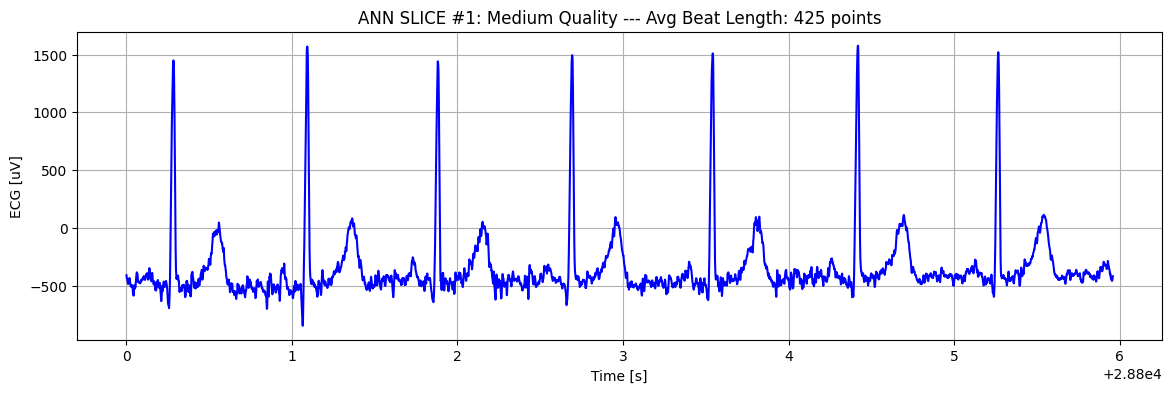

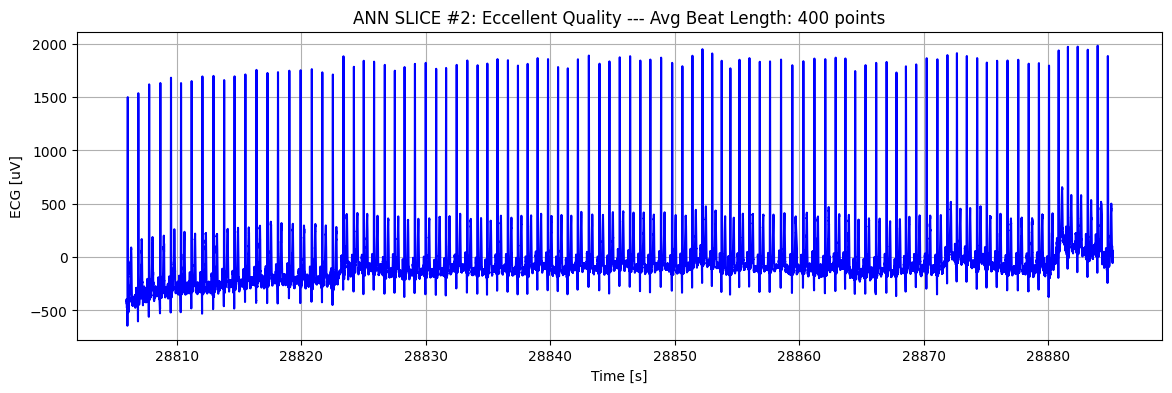

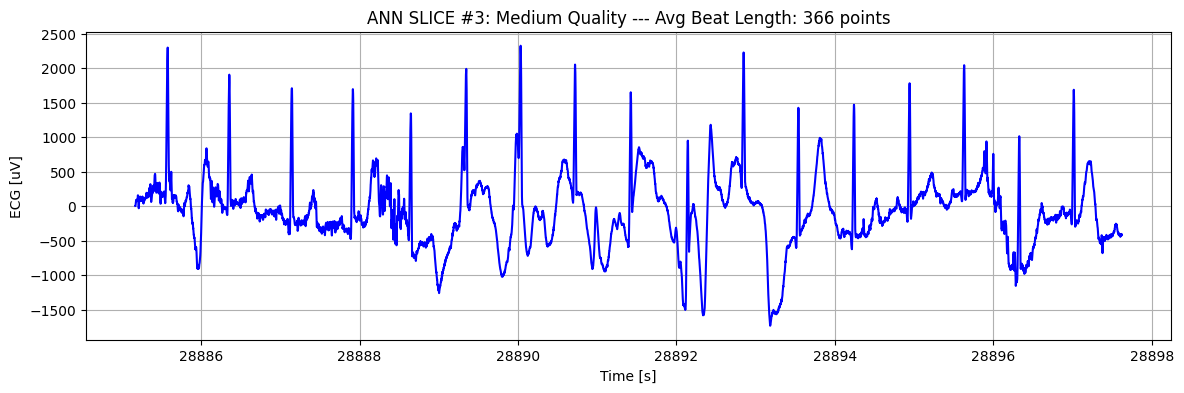

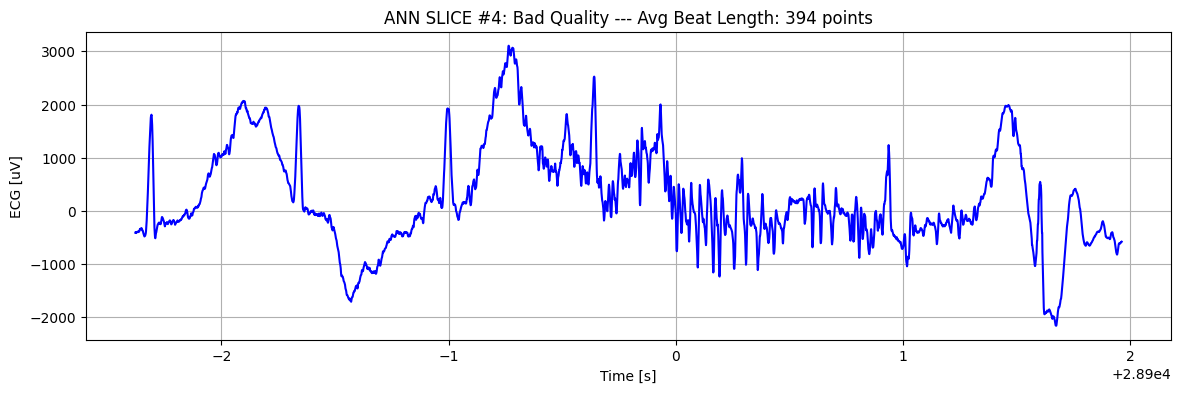

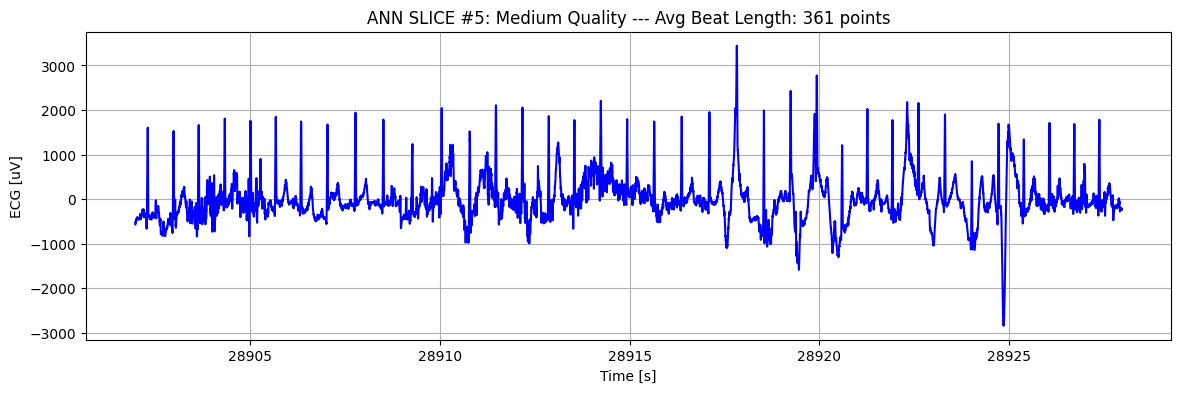

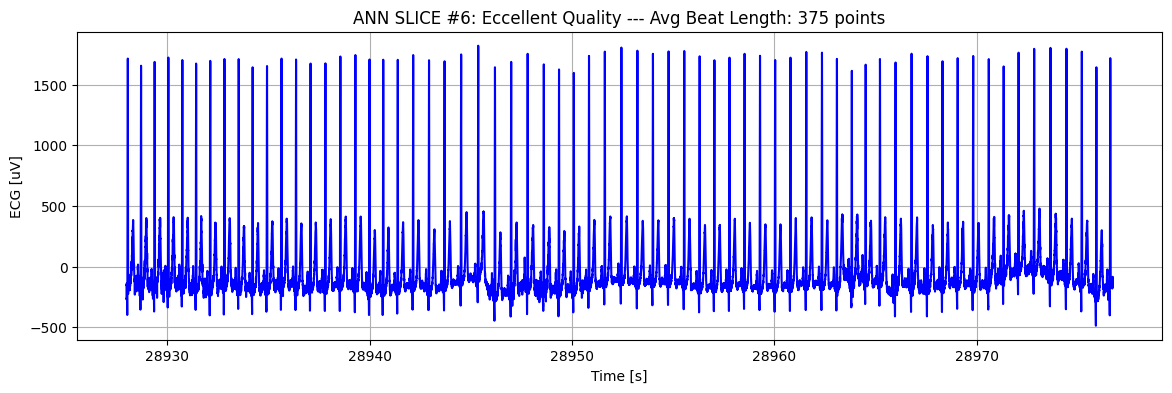

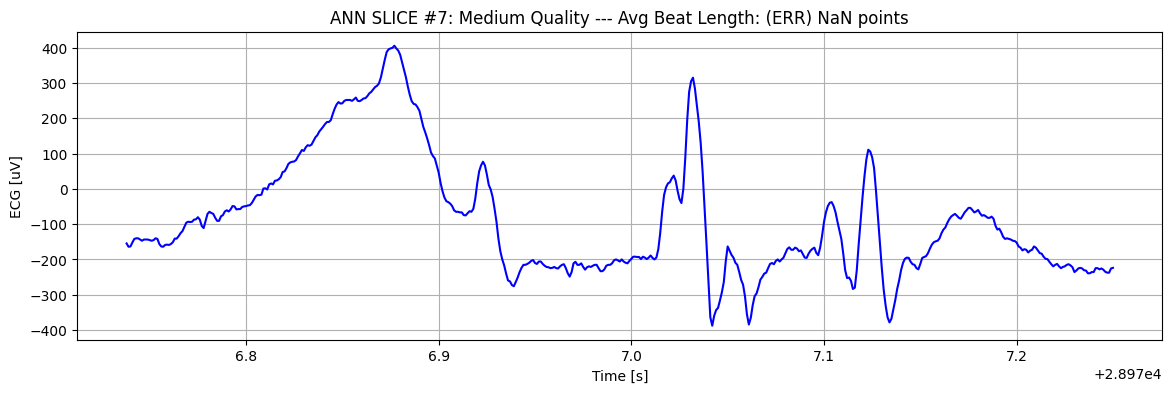

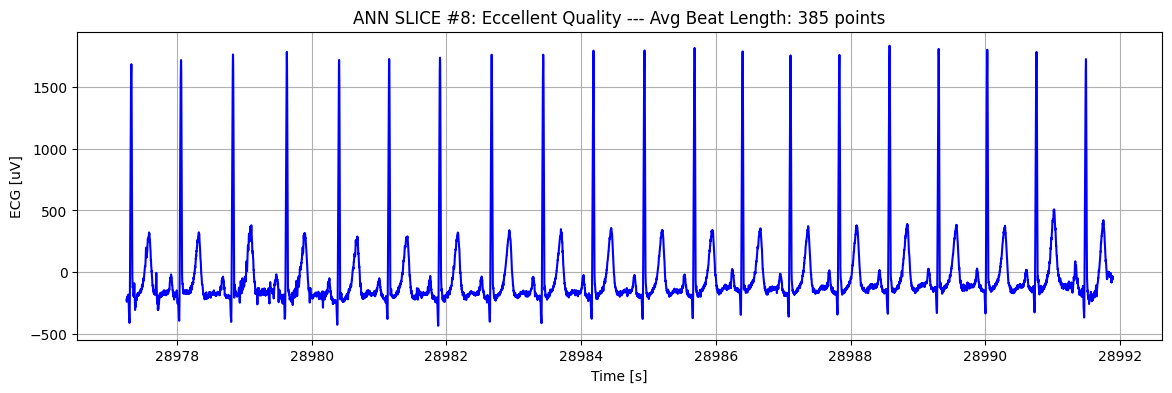

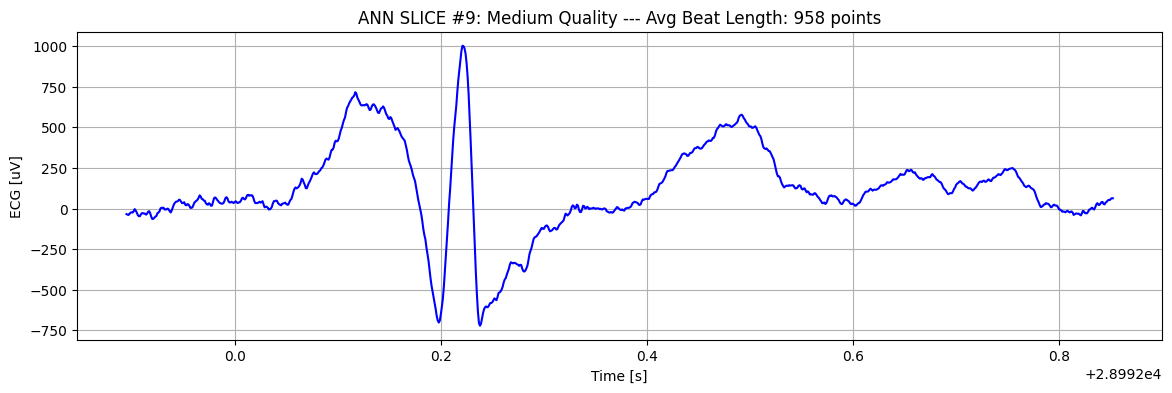

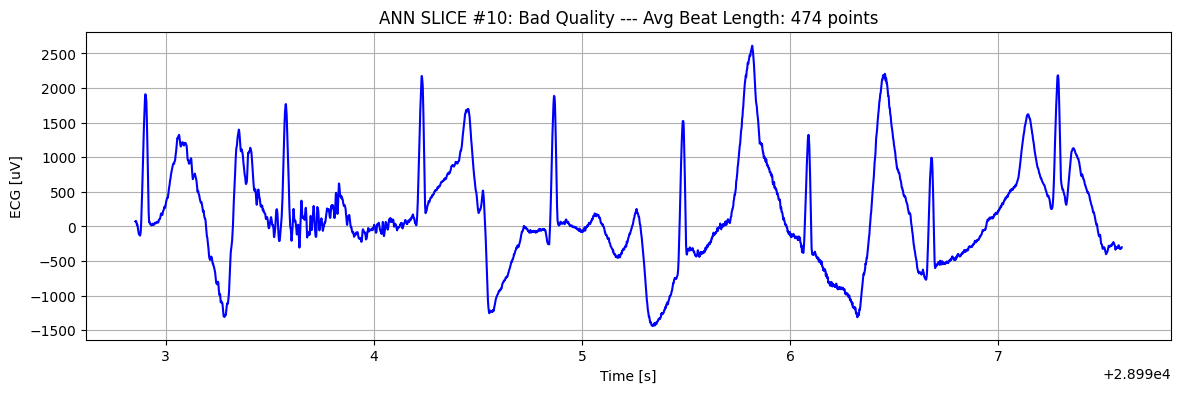

In [9]:
plot_ann_slices_ecg(but_qdb_path, patient_index, num_slices=10, remove_not_ann=True)

In [10]:
def plot_ecg_windows(dataset_path, patient_index, max_plots = 10, step_size = 10*ecg_sf, units='secs', remove_not_ann=True):

    assert units in ['secs', 'points'], "Invalid units"

    start_ann, end_ann, labels_ann = load_ann_from_patient(dataset_path, patient_index, remove_not_ann)

    labels_map ={1 : 'Eccellent Quality', 2 : 'Medium Quality', 3 : 'Bad Quality', 0 : 'Not annotated'}

    time_ecg = np.arange(len(ecg_signal)) / ecg_sf

    # Contatore per tracciare il numero di grafici generati
    plot_count = 0

    for index_out, (start, end, ann) in enumerate(zip(start_ann, end_ann, labels_ann)):

        # renaming ECG segment and time
        segment = ecg_signal[int(start) : int(end)]
        time_segment = time_ecg[int(start) : int(end)]

        # Utilizzare un ciclo for con range e passo per scorrere il segmento
        for window_start in range(0, len(segment), step_size):

            if plot_count >= max_plots:
                break

            window_end = window_start + step_size
            if window_end > len(segment):
                window_end = len(segment)

            # Calcolo n. di picchi R per stimare la lunghezza media del battito
            qrs_inds = processing.gqrs_detect(segment[window_start : window_end].copy().flatten(), fs=ecg_sf)

            # Plot di alcune finestre
            plt.figure(figsize=(14, 4))
            plt.plot(time_segment[window_start : window_end], segment[window_start : window_end], color='b')

            if units == 'secs':

                # Calcolare gli intervalli RR per stimare la lunghezza media di un battito
                if len(qrs_inds) > 1:
                    # Convertire gli intervalli in secondi
                    rr_intervals = np.diff(qrs_inds) / ecg_sf
                    avg_beat_duration = np.mean(rr_intervals)
                else:
                    avg_beat_duration = 0

                # lunghezza del segnale / n picchi R => lunghezza media battito
                # change title if the plot is truncated
                if window_end == len(segment):
                  plt.title(f'PLOT #{plot_count + 1}, ANN SLICE #{index_out + 1} : {labels_map[int(ann)]} --- Avg Beat Length: {avg_beat_duration:.3f} secs --- TRUNCATED !!!', color = 'r')
                else:
                  plt.title(f'PLOT #{plot_count + 1}, ANN SLICE #{index_out + 1} : {labels_map[int(ann)]} --- Avg Beat Length: {avg_beat_duration:.3f} secs', color = 'k')

            elif units == 'points':

                n_r_peaks = len(qrs_inds)
                n_signal_samples = len(segment[window_start : window_end])

                # lunghezza del segnale / n picchi R => lunghezza media battito
                # change title if the plot is truncated
                if window_end == len(segment):
                  plt.title(f'PLOT #{plot_count + 1}, ANN SLICE #{index_out + 1} : {labels_map[int(ann)]} --- Avg Beat Length: {n_signal_samples // n_r_peaks if n_r_peaks > 0 else "No Peak found"} points --- TRUNCATED !!!', color = 'r')
                else:
                  plt.title(f'PLOT #{plot_count + 1}, ANN SLICE #{index_out + 1} : {labels_map[int(ann)]} --- Avg Beat Length: {n_signal_samples // n_r_peaks if n_r_peaks > 0 else "No Peak found"} points', color = 'k')

            plt.xlabel('Time [s]')
            plt.ylabel(f'ECG [{ecg_units[0]}]')
            plt.grid()
            plt.savefig('/content/plot_windows_p' + str(patient) +'_plt' + str(plot_count + 1) + '_slice' + str(index_out + 1) + '_' + str(units) + '.png')
            plt.show()

            plot_count += 1
            if plot_count >= max_plots:
                break

            # Interrompe il ciclo se abbiamo raggiunto la fine del segnale
            if window_end == len(segment):
                #print('The above signal is truncated !!!')
                break

        # plot only a portion of original signal
        if plot_count >= max_plots:
          break

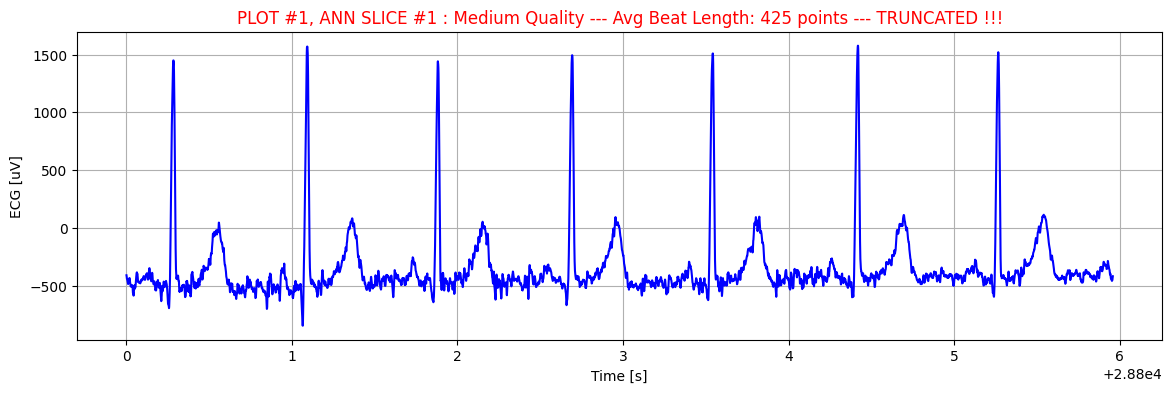

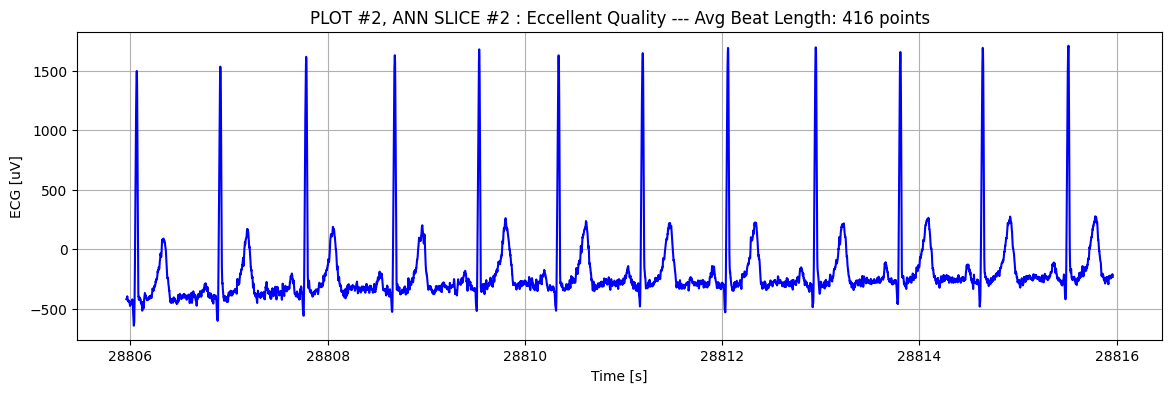

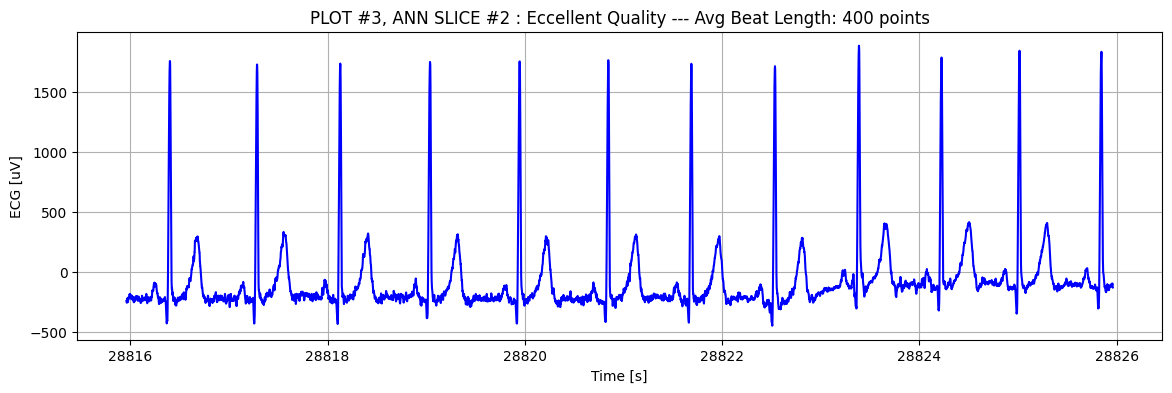

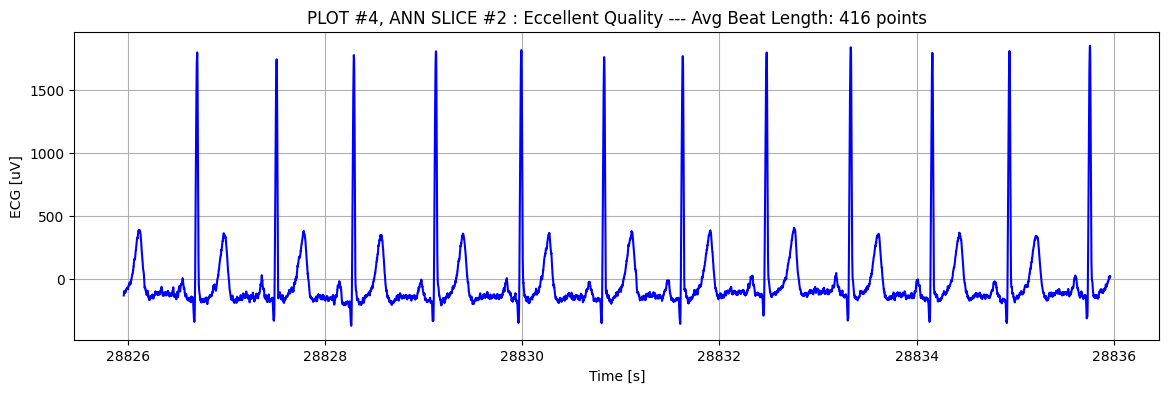

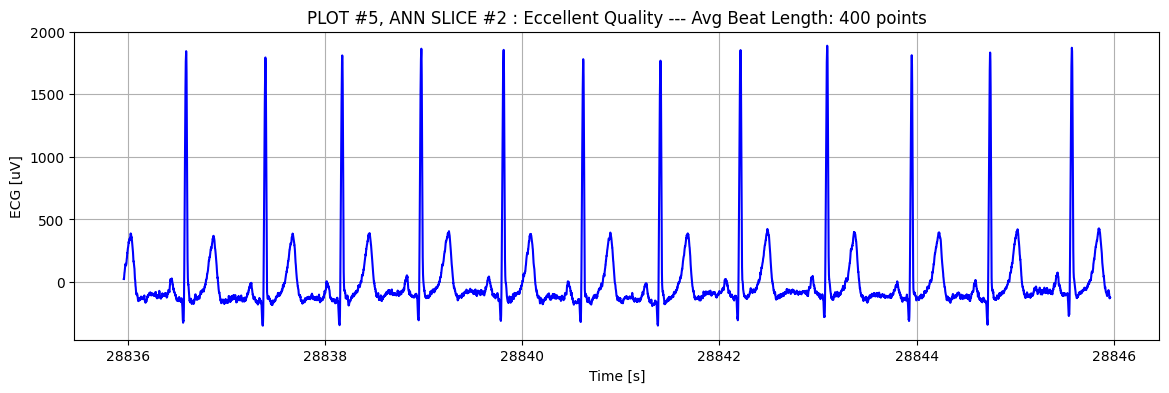

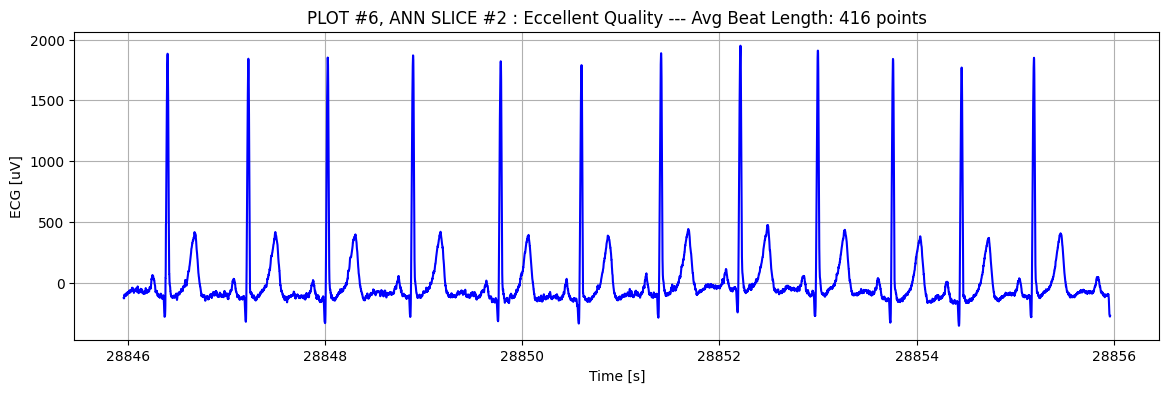

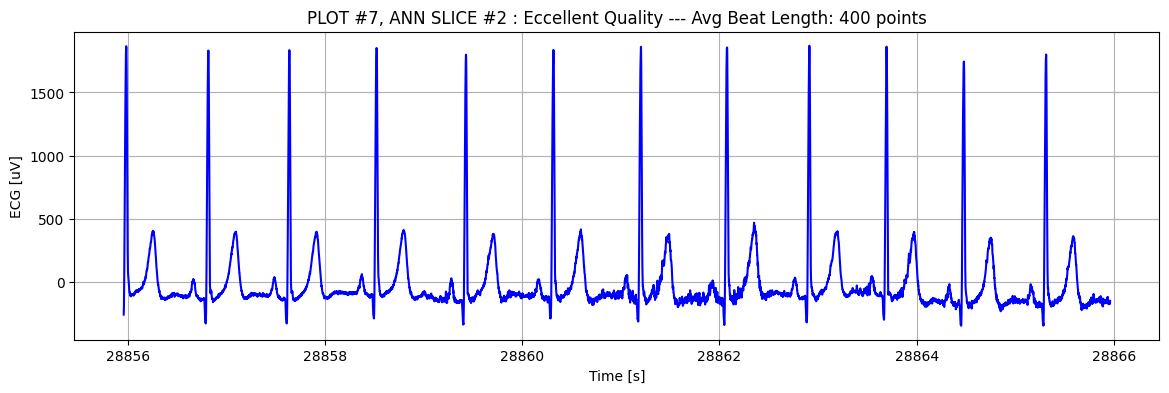

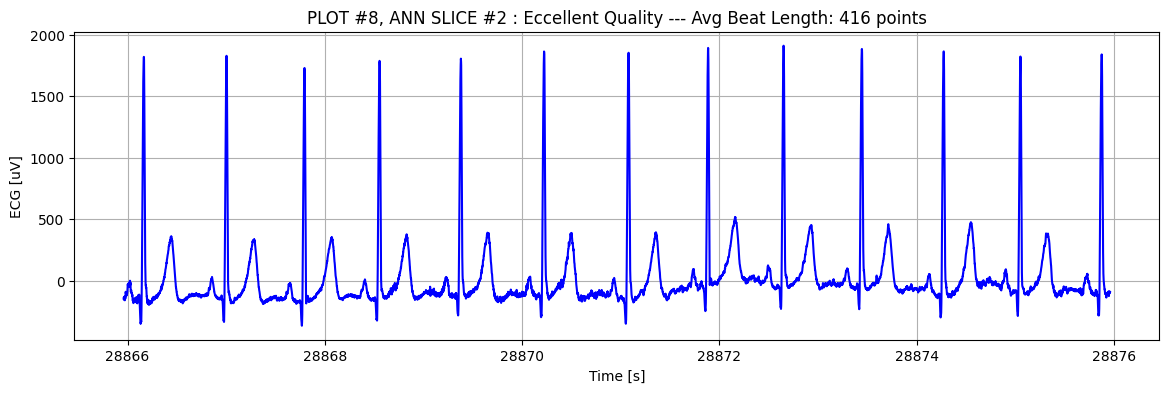

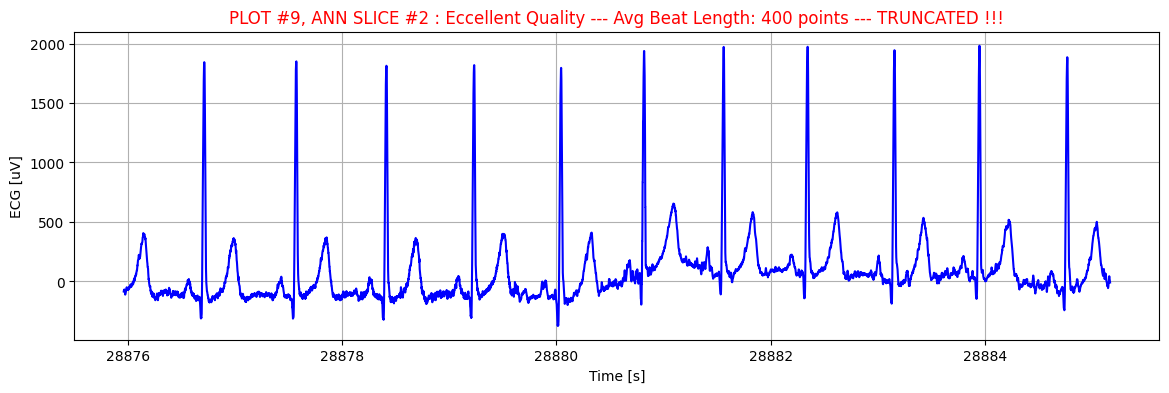

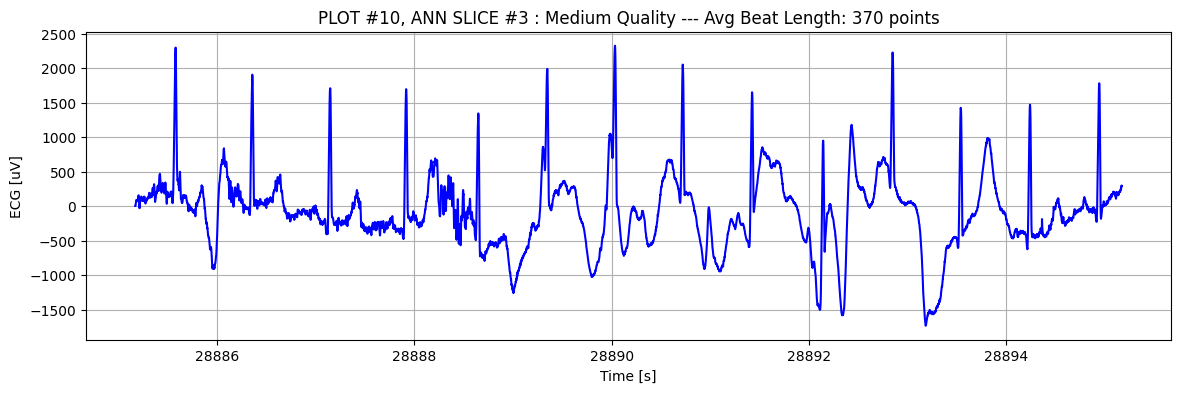

In [11]:
# unit measure is 'points'
plot_ecg_windows(but_qdb_path, patient_index, max_plots = 10, step_size = 10*ecg_sf, units='points', remove_not_ann = True)

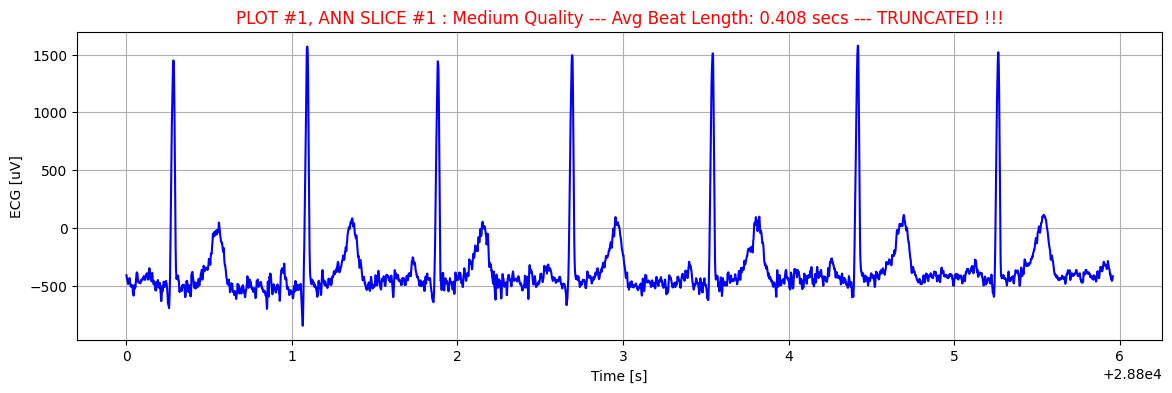

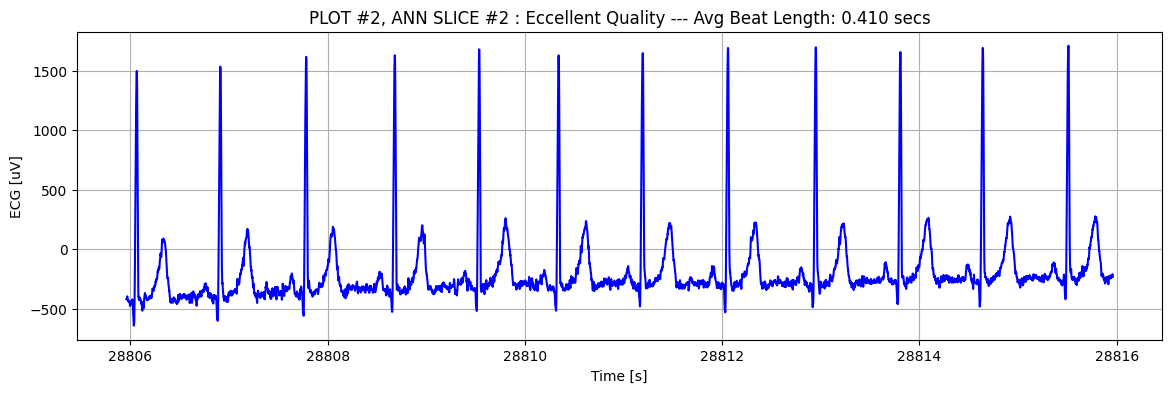

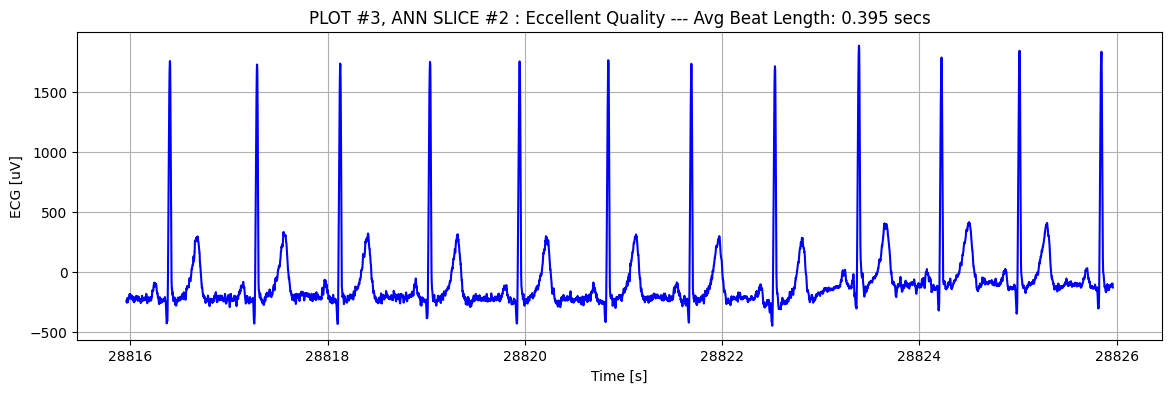

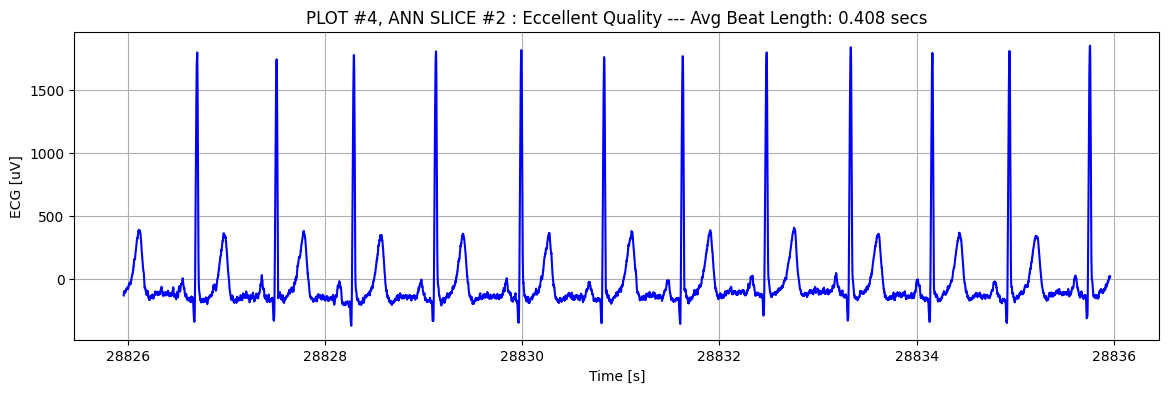

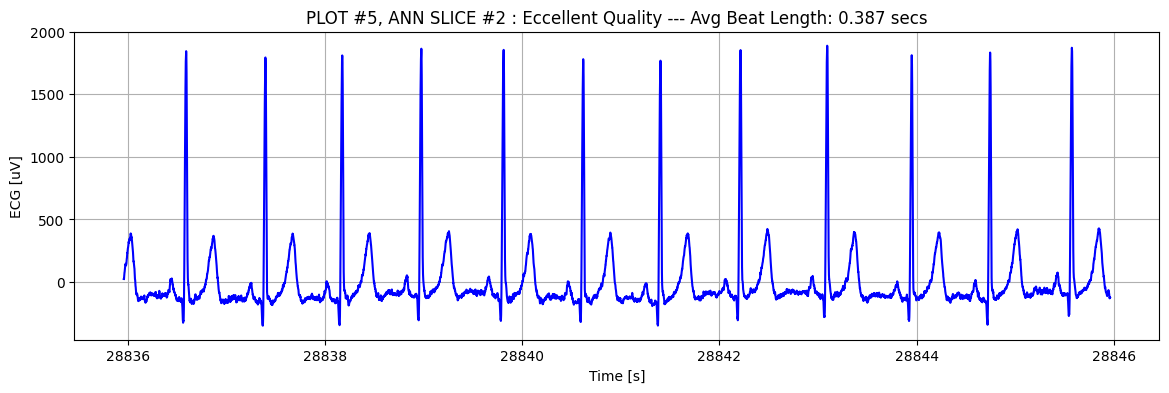

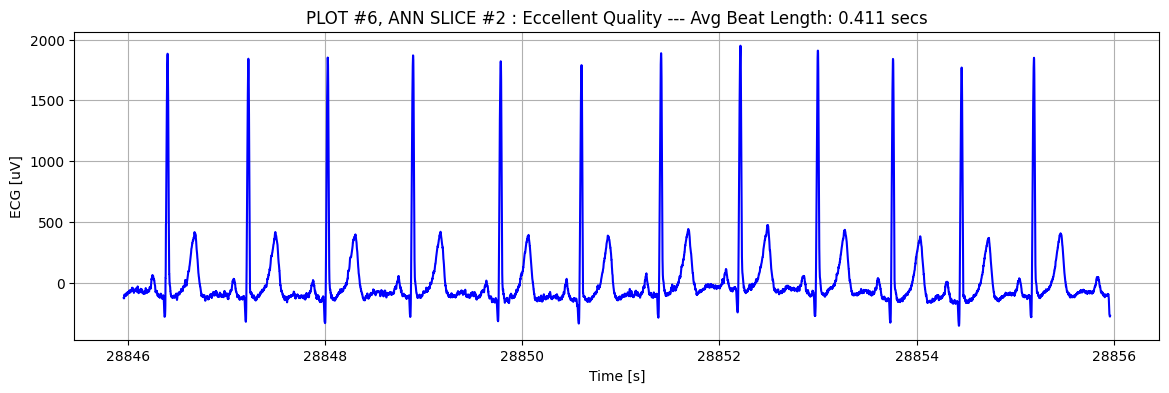

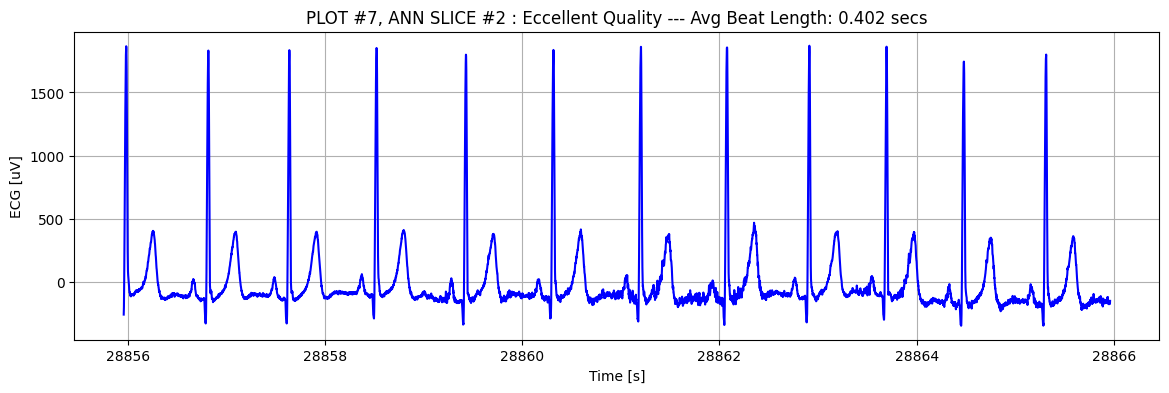

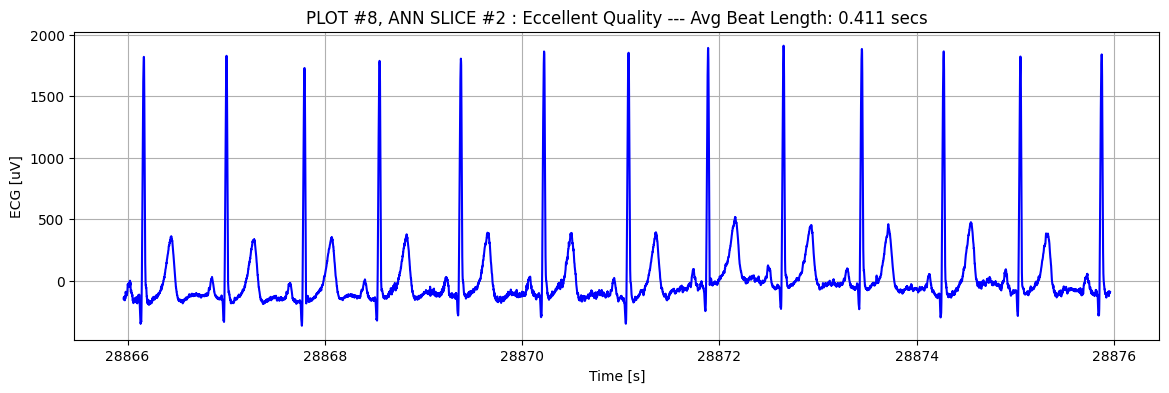

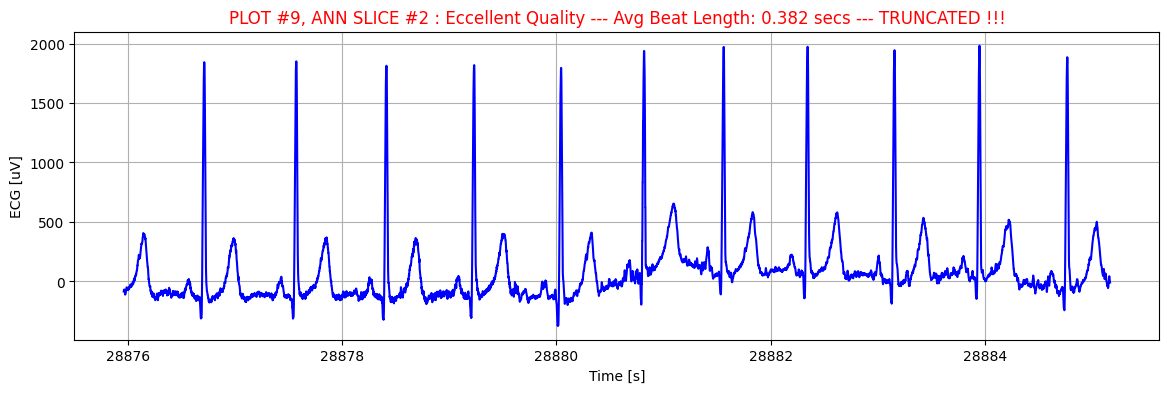

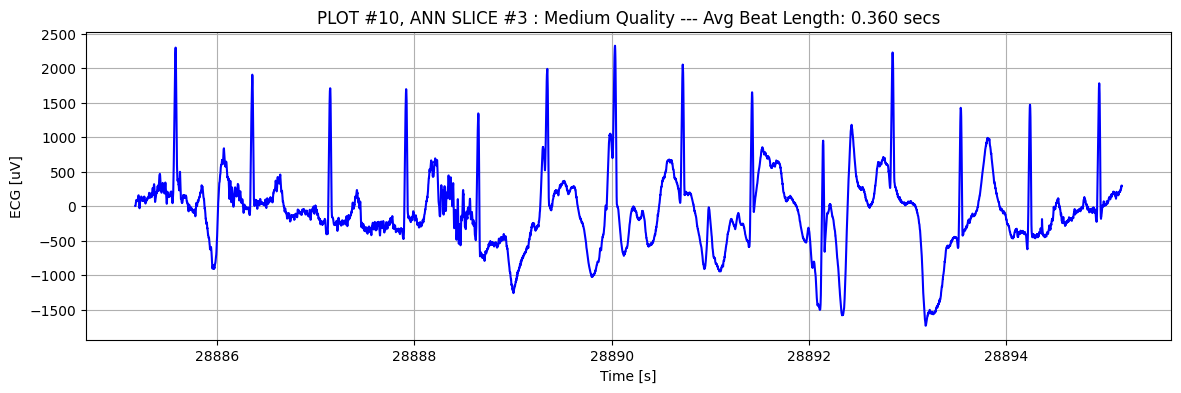

In [12]:
# unit measure is 'secs'
plot_ecg_windows(but_qdb_path, patient_index, max_plots = 10, step_size = 10*ecg_sf, units='secs', remove_not_ann=True)